In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch

from experiments import *
import autoencoders as ae
import wandb

In [2]:
wandb.init(project="contrastive test (umap)")

wandb: Currently logged in as: waleko (ai-prentice). Use `wandb login --relogin` to force relogin


In [ ]:
suite = ae.TrajectoryContrastiveSuite(Pendulum, contrastive_loss=ae.lifted_structured_loss(5, 1, 1), batch_size=128, epochs=500, do_animate=True)
model = suite.train(40, 200)

In [ ]:
loss, mse = suite.test_num(model)
print(loss, mse)

In [ ]:
x, x_prime, dyn, cons = suite.try_transform_num(model, 2)
print(cons.min(), cons.max())
plt.scatter(x[:, 0], x[:, 1], c='black', s=0.01)
plt.scatter(x_prime[:, 0], x_prime[:, 1], c=dyn, s=1)

In [ ]:
x, x_prime, dyn, cons = suite.try_transform_num(model, 2)
print(cons.min(), cons.max())
plt.scatter(x[:, 0], x[:, 1], c='black', s=0.01)
plt.scatter(x_prime[:, 0], x_prime[:, 1], c=dyn, s=1)

## UMAP & Wasserstein experiments

In [11]:
exp = CoupledOscillator
target_embedding, dist_matrix = exp.calc_umap_wd(200, 200)

Normalizing
Computing distance matrix
Embedding data and computing scores


C:\Users\waleko\anaconda3\lib\site-packages\umap\umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
C:\Users\waleko\anaconda3\lib\site-packages\umap\umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
C:\Users\waleko\anaconda3\lib\site-packages\umap\umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
C:\Users\waleko\anaconda3\lib\site-packages\umap\umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
C:\Users\waleko\anaconda3\lib\site-packages\umap\umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable

Computing the dimensionality


In [13]:
target_embedding_tensor = torch.tensor(target_embedding).float()

def umap_mse(embedding, labels, lambda_=0.1):
    global target_embedding_tensor
    return torch.mean((embedding - target_embedding_tensor[labels.long(),])**2) * lambda_

Using cpu device...


  0%|          | 0/500 [00:00<?, ?it/s]

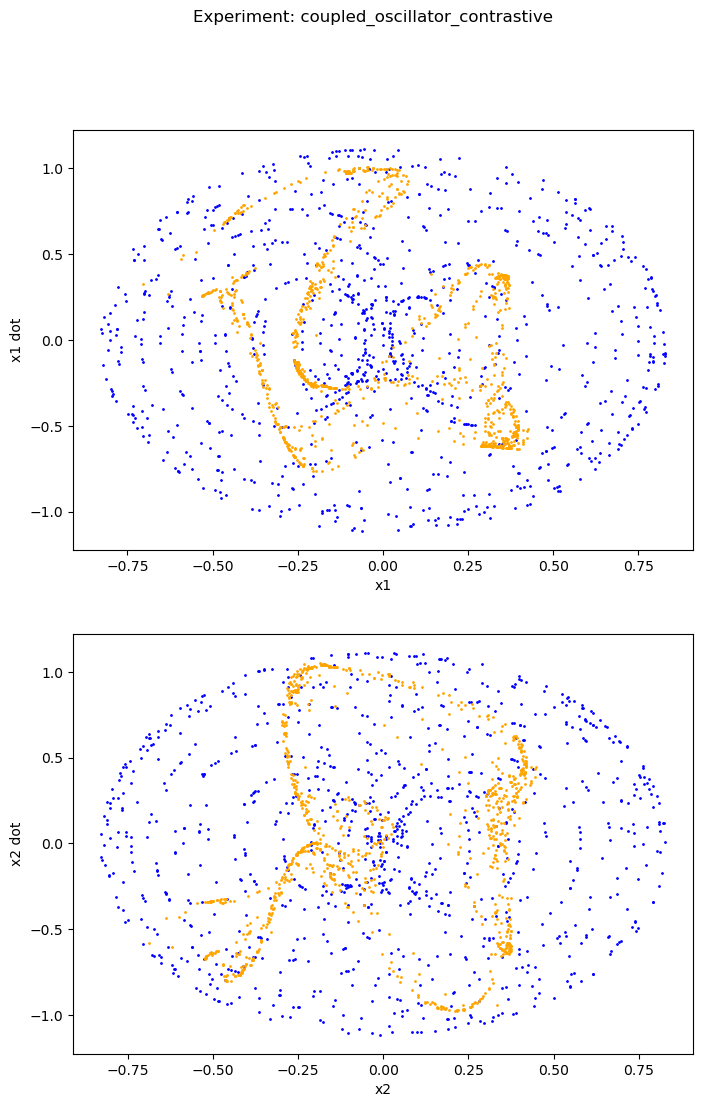

In [15]:
suite = ae.TrajectoryContrastiveSuite(exp, contrastive_loss=umap_mse, batch_size=128, epochs=500, do_animate=True)
model = suite.train(80, 200)

In [ ]:
x = exp.contrastive_data(20, 20)
data = x[:, 1:]
labels = x[:, 0]
emb = model.encoder(torch.tensor(data).float())[:, 2:]

In [ ]:
loss = ae.center_loss(emb, torch.tensor(labels).long())

In [ ]:
loss, mse = suite.test_num(model)
print(loss, mse)

In [ ]:
x = exp.data[0]
x_prime, dyn, cons = suite.try_transform(model, x)
print(cons[:, 0].min(), cons[:, 0].max())
plt.scatter(x[:, 0], x[:, 1], c='black', s=0.01)
plt.scatter(x_prime[:, 0], x_prime[:, 1], c=dyn[:, 0], s=1)

In [ ]:
x, x_prime, dyn, cons = suite.try_transform_num(model, 2)
print(cons[:, 0].min(), cons[:, 0].max())
plt.scatter(x[:, 0], x[:, 1], c='black', s=0.01)
plt.scatter(x_prime[:, 0], x_prime[:, 1], c=dyn[:, 0], s=1)

### Wasserstein experiments

In [16]:
dist_matrix_tensor = torch.tensor(dist_matrix).float()

def wasserstein_mse(embedding, labels):
    global dist_matrix_tensor
    center_loss = ae.center_loss(embedding, labels)
    dist_loss = ae.diff_between_distances(embedding, labels, dist_matrix_tensor)
    return (center_loss + dist_loss) * 0.01

In [ ]:
suite = ae.TrajectoryContrastiveSuite(exp, batch_size=256, contrastive_loss=wasserstein_mse, epochs=1000, do_animate=True)
# data = exp.contrastive_data(1)
model = suite.train(80, 200)
# model = suite.train_traj_data(data)

Using cpu device...


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
res = suite.try_transform(model, data[:, 1:])[0]

In [ ]:
loss, mse = suite.test_num(model)
print(loss, mse)

In [ ]:
x = exp.data[0]
x_prime, dyn, cons = suite.try_transform(model, x)
print(cons[:, 0].min(), cons[:, 0].max())
plt.scatter(x[:, 0], x[:, 1], c='black', s=0.01)
plt.scatter(x_prime[:, 0], x_prime[:, 1], c=dyn[:, 0], s=1)

In [4]:
exp = CoupledOscillator

In [3]:
import creating.coupled_oscillator as co

In [ ]:
x = exp.contrastive_data()[:, 1:]
x_prime, dyn, cons = suite.try_transform(model, x)
print(cons[:, 0].min(), cons[:, 0].max())
cons0, cons1 = cons[:, 0], cons[:, 1]
y_true = [co.energy(e) for e in x]
plt.scatter(cons0, cons1, c=y_true, s=0.01)
plt.scatter(cons0[:1000], cons1[:1000], c=y_true[:1000], s=10)

In [6]:
exp.contrastive_data()

array([[ 0.00000000e+00, -3.68090511e-01,  2.49361401e-01,
         2.43937149e-01, -7.58637401e-01],
       [ 0.00000000e+00,  3.67948253e-01, -2.05588694e-01,
        -7.90317660e-01,  2.87672334e-01],
       [ 0.00000000e+00, -3.74083170e-01,  4.49085124e-01,
         9.10811771e-02,  4.31783679e-01],
       ...,
       [ 1.99000000e+02,  1.61693560e-01,  6.77466082e-01,
         8.87289519e-01,  2.40426386e-01],
       [ 1.99000000e+02,  9.74800824e-01,  3.77938259e-01,
        -3.83267216e-01,  1.12975293e-03],
       [ 1.99000000e+02, -8.36526965e-01, -5.40513832e-01,
        -6.29416204e-01,  3.47120776e-01]])

In [7]:
traj = exp.contrastive_data()[:, 1:]
energy_true = [co.energy(e) for e in traj]

In [ ]:
plt.scatter(target_embedding[:200, 0], target_embedding[:200, 1], c=y_true[::1000][:200])